In [ ]:
#SCRAPE MULTIPLE FINANCIAL PARAMETERS FROM SINGLE PAGE / V2 / Faster scrolling using drag&drop apprach
#https://stackoverflow.com/questions/62119348/how-to-scroll-horizontally-using-selenium-chromedriver-in-python

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.action_chains import ActionChains

import pandas as pd
import matplotlib.pyplot as plt
import time

In [ ]:
#ToDo
#Add Support for balanse-sheet,cashflow-statement,financial-ratios and other

In [ ]:
class ScrapeMacrotrend:
    
    def __init__(self, ticker_name):
        
        self.start = time.time() #start timer
        self.ticker_name = ticker_name #ticker or company name
        
        #innitialize and set chrome-webdriver options
        self.chrome_options = Options()
        #self.chrome_options.add_argument("--window-size=1000,1080")
        #self.chrome_options.add_argument("--headless")
        
        self.driver = webdriver.Chrome("G:\My Drive\Investing\Programming\chromedriver.exe", options=self.chrome_options)
        self.driver.implicitly_wait(5)
        self.driver.maximize_window()
        self.base_url = "https://www.macrotrends.net/"
        
        self.ad_clicked = False
        self.company_url = self.getCompanyURL()
        
        #scrape main pages
        # self.income_statement = self.runScraper(self.company_url + "/income-statement?freq=Q")
        # self.balance_sheet = self.runScraper(self.company_url + "/balance-sheet?freq=Q")
        # self.cash_flow_statement = self.runScraper(self.company_url + "/cash-flow-statement?freq=Q")
        self.temp_data = []
        # self.financial_ratios = self.runScraper(self.company_url + "/financial-ratios?freq=Q")
        self.financial_ratios = self.runFullTableScrape(self.company_url + "/financial-ratios?freq=Q")

        
        self.driver.close() #close chrome-webdriver
        self.end = time.time() #stop timer
        print('Complete time: {}s'.format(self.end - self.start))

        
        
        
    def getCompanyURL(self): #this function finds the company url f.e. https://www.macrotrends.net/stocks/charts/AAPL/apple
        self.driver.get(self.base_url)
        self.search_box = self.driver.find_element_by_css_selector("input.js-typeahead")
        self.search_box.send_keys(self.ticker_name)
        
        #get company url
        self.company_url = self.driver.find_element_by_xpath("//li[1]/a") #xpath element of the company urls
        self.company_url = self.company_url.get_attribute('href') #get the href-value
        self.company_url = self.company_url.rsplit("/", 1)[0] #split url to remove unnecesery data
        
        return self.company_url
        
        
    def runScraper(self, url):
        
        #scraper variables
        self.periods_table_prev_last_elem = -1 #previously(before scrolling) last scraped element of periods-table
        self.periods_table_current_last_elem = 0 #current(after scrolling) last scraped element of periods-table
        self.main_table_prev_last_elem = -1  #previously(before scrolling) last scraped element of main-table
        self.main_table_current_last_elem = 0 #current(after scrolling) last scraped element of main-table

        #data-storring variables
        self.periods_table_data = [] #store data from periods table (annual or quarter)
        self.main_table_data = [] #store data from the main-table like revenue, 
        self.all_scraped_data = pd.DataFrame()
        
        self.driver.get(url)

        #find advertise window button and click it
        if self.ad_clicked == False:
            self.ad_button = self.driver.find_element_by_xpath('//button[@class="Button__StyledButton-a1qza5-0 cUAUIG"]')
            self.ad_button.click()
            self.ad_clicked = True


        self.horizontal_bar_width = self.driver.find_element_by_id('jqxScrollOuterWraphorizontalScrollBarjqxgrid').rect['width']
        self.slider = self.driver.find_element_by_id('jqxScrollThumbhorizontalScrollBarjqxgrid')
        
        
        #get table-parameter-names
        full_table_params = []
        full_table_params_and_values = []
        full_table = self.driver.find_element_by_css_selector("#contentjqxgrid")
        full_table = full_table.text.splitlines()
        for item in full_table:
            if item[-1].isdigit()==False and item[-1] != "-" and item !="www.jqwidgets.com" :
                full_table_params.append(item)

        j=-1
        for item in full_table:
            if item == "www.jqwidgets.com":
                continue
            elif item in full_table_params:
                j=j+1
                full_table_params_and_values.append([item])
                continue
            full_table_params_and_values[j].append(item)


        print(full_table_params_and_values)
        self.driver.close()
        raise SystemExit("Stop right there!")

        #scroll table from left to right and scrape data
        while (self.periods_table_prev_last_elem != self.periods_table_current_last_elem): #and (self.main_table_prev_last_elem != self.main_table_current_last_elem):
            
            ##########################################################################
            # full_table = self.driver.find_element_by_xpath("//div[@id='jqxgrid']")
            # full_table = self.driver.find_element_by_css_selector("#contentjqxgrid")
            # full_table = full_table.text.splitlines()
            # self.temp_data.append(full_table)
            # print(full_table)
            ###########################################################################

            #set the last element from the last scrape as previous one
            self.periods_table_prev_last_elem = self.periods_table_current_last_elem
            self.main_table_prev_last_elem = self.main_table_current_last_elem

            # self.periods_table = self.driver.find_element_by_xpath('//*[@id="columntablejqxgrid"]') 
            self.periods_table = self.driver.find_element_by_xpath('//*[@id="contentjqxgrid"]/div[1]') #this is the header row in the table, containing the dates.
            # print(self.periods_table.text)
            #parameters_table = self.driver.find_element_by_xpath('//*[@id="contentjqxgrid"]/div[2]')
            self.periods_table_split = self.periods_table.text.splitlines() #split the periods to array
            self.periods_table_current_last_elem = self.periods_table_split[-1] #get the last element from the table
            # print(len(self.periods_table_split), "periods")
            # print('last-element={}'.format(self.periods_table_current_last_elem))

            # main_table = self.driver.find_elements_by_xpath('//div[@role="row"]') #get the main table
            main_table = self.driver.find_elements_by_xpath('//*[@id="contentjqxgrid"]/div[2]/div/div') #get the main table
            self.main_table_current_last_elem = main_table[0].text.splitlines()[-1]
            # print(len(main_table[0].text.splitlines()), "main")
            #print(self.main_table_current_last_elem)
            
            #this is the innitial position of the table, no scrolling has been executed yet
            if self.periods_table_prev_last_elem == 0: 
                #add scraped elements of periods table to a temp-variable 
                self.periods_table_data.extend(self.periods_table_split) 
                
                #add the scraped elements of main-table to a temp-variable
                for i in range (len(main_table)): #add all parameter to table
                    main_table_split = main_table[i].text.splitlines()
                    self.main_table_data.append(main_table_split)

            else:
                #find the previous last element when the periods-table is scrolled to the right
                self.periods_table_prev_last_elem_index = self.periods_table_split.index(self.periods_table_prev_last_elem)
                #add the new elements after the periods-table is scrolled to the right
                self.periods_table_data.extend(self.periods_table_split[self.periods_table_prev_last_elem_index+1:]) 
                # print(self.periods_table_split)
                
                #find the previous last element when the main-table is scrolled to the right
                self.main_table_prev_last_elem_index = main_table[0].text.splitlines().index(self.main_table_prev_last_elem) 
                # print(main_table[0].text.splitlines())
                #add the new elements after the main-table is scrolled to the right
                for row in range (len(main_table)): #add the new data to the table after scrolling table to the right
                    main_table_split = main_table[row].text.splitlines()
                    self.main_table_data[row].extend(main_table_split[self.main_table_prev_last_elem_index+1:])
                


                # raise SystemExit("Stop right there!")

            # Ensure the slider is in view
            self.slider.location_once_scrolled_into_view
            #scroll table to the right
            ActionChains(self.driver).click_and_hold(self.slider).move_by_offset(self.horizontal_bar_width/5, 0).release().perform()

        
        #add the scraped data to pandas dataframe
        for i in range (len(self.main_table_data)):
            #create temp dataframe with scraped data
            # print(self.main_table_data[i], self.periods_table_data)
            data = pd.DataFrame([self.main_table_data[i][1:]], columns=self.periods_table_data[1:], index=[self.main_table_data[i][0]]) 
            
            #append temp-dataframe row to global dataframe
            self.all_scraped_data = pd.concat([self.all_scraped_data, data]) 

        
        #return scraped data
        return self.all_scraped_data
    
    def runFullTableScrape(self, url):

        self.driver.get(url)

        #variables
        full_table_params = [] #collect table parameters - Periods, Revenue, Cost Of Goods Sold ..
        full_table_params_and_values = [] #collect parameters and values
        full_table_params_and_values_set = [] #store scraped data as array-of-sets instead of array-of-arrays

        #find advertise window button and click it
        if self.ad_clicked == False:
            self.ad_button = self.driver.find_element_by_xpath('//button[@class="Button__StyledButton-a1qza5-0 cUAUIG"]')
            self.ad_button.click()
            self.ad_clicked = True


        self.horizontal_bar_width = self.driver.find_element_by_id('jqxScrollOuterWraphorizontalScrollBarjqxgrid').rect['width']
        self.slider = self.driver.find_element_by_id('jqxScrollThumbhorizontalScrollBarjqxgrid')

        while True:

            #get table-parameter-names
            full_table = self.driver.find_element_by_css_selector("#contentjqxgrid")
            full_table = full_table.text.splitlines()
            for item in full_table:
                if item[-1].isdigit()==False and item[-1] != "-" and item !="www.jqwidgets.com" :
                    full_table_params.append(item)

            #get table parameters names and values
            j=-1
            for item in full_table:
                if item == "www.jqwidgets.com":
                    continue
                elif item in full_table_params:
                    j=j+1
                    full_table_params_and_values.append([item])
                    continue
                full_table_params_and_values[j].append(item)

            #convert data from array-of-arrays to array-of-sets
            for i in range(len(full_table_params_and_values)):
                temp_set = set(full_table_params_and_values[i])
                full_table_params_and_values_set.append(item)

            # print(full_table_params_and_values)
            self.driver.close()
            raise SystemExit("Stop right there!")


tesla = ScrapeMacrotrend("tesla")

In [49]:
#scrape the data
import requests
import json
from html.parser import HTMLParser
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#HTML parser that help to parse html-strings
#https://www.educative.io/answers/what-is-the-html-parser-in-python
class Parser(HTMLParser):
  def handle_data(self, data):
    self.output = data
parser = Parser()


class ScrapeMacrotrend():

    def __init__(self, ticker_search):
        
        url = self.get_company_page_url(ticker_search) #find url for the respective company based on ticker-name
        # url = 'https://www.macrotrends.net/stocks/charts/TSLA/tesla/income-statement?freq=Q'

        #scrape company quarter data
        self.financial_statements_quarter = self.scrape_the_data(url + '/income-statement?freq=Q')
        self.balance_sheet_quarter = self.scrape_the_data(url + '/balance-sheet?freq=Q')
        self.cash_flow_quarter = self.scrape_the_data(url + '/cash-flow-statement?freq=Q')
        self.financial_ratios_quarter = self.scrape_the_data(url + '/financial-ratios?freq=Q')
        
        #scrape company anual data
        self.financial_statements_annual = self.scrape_the_data(url + '/income-statement?freq=A')
        self.balance_sheet_annual = self.scrape_the_data(url + '/balance-sheet?freq=A')
        self.cash_flow_annual = self.scrape_the_data(url + '/cash-flow-statement?freq=A')
        self.financial_ratios_annual = self.scrape_the_data(url + '/financial-ratios?freq=A')
        

    def get_company_page_url(self, ticker_search):
        # ticker_search = 'AAPL'
        #get ticker data
        tickers_url = 'https://www.macrotrends.net/assets/php/ticker_search_list.php?_=1664947632720'
        data_tickers = requests.get(tickers_url)
        data_tickers = data_tickers.text
        data_tickers_json = json.loads(data_tickers)

        #search for the company-url
        for item in data_tickers_json:
            # print(item['s'])
            if ticker_search in item['s']: #example: AAPL/apple
                company_page_url = item['s']
                print("company-url={}".format(company_page_url))

        return 'https://www.macrotrends.net/stocks/charts/' + company_page_url


    def scrape_the_data(self, url):

        page = requests.get(url)
        page_lines = page.text.splitlines()
        for line in page_lines:
            if 'var originalData =' in line: #the line where all the data is storred
                data = line #store the information in a variable

        data = data[20:-1] # remove the the unneeded informatino from the line
        data_json = json.loads(data) #convert the line to a json-object

        #the following vars are needed when looping through the json_
        data_index = [] #collect the data-names
        data_column = [] #collect the data-dates
        data_values = [] #collect the data-values

        #loop over 
        for item in data_json:

            #reset temp-vars for the next loop
            data_values_temp = [] #store data-values for current loop
            data_column_temp = [] #store data-dates for current loop

            for key in item.items() :
                # print(key[0], key[1])

                if (key[0] != 'field_name') and (key[0] != 'popup_icon'): # dates and values
                    # print(key[0], key[1])
                    data_column_temp.append(key[0]) #dates
                    data_values_temp.append(key[1]) #values

                elif key[0] == 'field_name': #data-names
                    # print(key[1])
                    parser.feed(key[1])
                    # print(parser.output)
                    data_index.append(parser.output) # xxx = "<a href='/stocks/charts/TSLA/tesla/cost-goods-sold'>Cost Of Goods Sold</a>"

                elif key[0]== 'popup_icon': #data-graph link (not needed)
                    continue
                    print(key[1])

            #add temp-vars to permanent ones
            data_values.append(data_values_temp)
            data_column.append(data_column_temp)


        # pd.DataFrame(data=data_values, index=data_index, columns=data_column, dtype=None, copy=None)
        company_data = pd.DataFrame(data=data_values, index=data_index, columns=data_column[0])
        company_data.apply(self.fixData)

        return company_data

    #apply-function that goes over all dataframe-elements and converts them to numeric value if possible
    def fixData(sekf, input_data):
        
        for i in range(len(input_data)):
        
            try:
                input_data[i] = pd.to_numeric(input_data[i])
                # print(type(input_data[i]), "converted to numeric")

            except:
                # pass
                print(input_data[i], "Can't convert to numeric")
            
        return input_data
        


    # company_data.dtypes
    # company_data.columns
    # company_data.index

    # company_data.loc['Revenue']
    # company_data.loc['EPS - Earnings Per Share']

    # company_data.columns = pd.to_datetime(company_data.columns) #change columns data-type to datetime.
    # company_data.columns

apple_data = ScrapeMacrotrend('AAPL')
tesla_data = ScrapeMacrotrend('TSLA')
microsoft_data = ScrapeMacrotrend('MSFT')


company-url=AAPL/apple
company-url=TSLA/tesla
company-url=MSFT/microsoft


In [ ]:
tesla_data.financial_statements_annual

[]

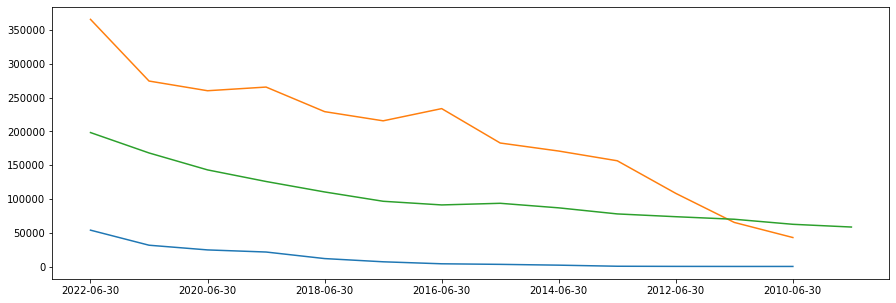

In [50]:
#plotting the data
f = plt.figure()
# tesla_data.financial_ratios_quarter.loc['Current Ratio'].plot()
# apple_data.financial_ratios_quarter.loc['Current Ratio'].plot()

tesla_data.financial_statements_annual.loc['Revenue'].plot()
apple_data.financial_statements_annual.loc['Revenue'].plot()
microsoft_data.financial_statements_annual.loc['Revenue'].plot()

f.set_figwidth(15)
f.set_figheight(5)

plt.plot()

In [ ]:
#remove "$" from the values
def fixData(input_data):
    
    for i in range(len(input_data)):
        input_data[i]=input_data[i].replace("$","")
        input_data[i]=input_data[i].replace(",",".")
        # try:
        #     input_data[i] =  float(input_data[i])
        #     # print(type(input_data[i]), input_data[i])
        # except:
        #     pass
        #     # print(input_data[i],"can't convert to float")
        
        try:
            input_data[i] = pd.to_numeric(input_data[i])
            # print(type(input_data[i]), "converted to numeric")

        except:
            pass
            # print("Can't convert to numeric")
        
    return input_data
    

c_data = company_data.copy()
c_data.apply(fixData)
# c_data.apply(pd.to_numeric)
c_data = c_data.T #transpose the table
# c_data.index.to_datetime()
c_data.index = pd.to_datetime(c_data.index) #change index data-type to datetime.
c_data

# c_data["Revenue"] = pd.to_numeric(c_data["Revenue"]) #convert data-type from string to number
# c_data["Gross Profit"] = pd.to_numeric(c_data["Gross Profit"]) #convert data-type from string to number
c_data["Revenue"].plot()
c_data["Gross Profit"].plot()
plt.show()

# company_data
#DataFrame.apply(func, axis=0, raw=False, result_type=None, args=(), **kwargs)
# df = pd.DataFrame({
#    'pig': [20, 18, 489, 675, 1776],
#    'horse': [4, 25, 281, 600, 1900]
#    }, index=[1990, 1997, 2003, 2009, 2014])
# lines = df.plot.line()
# df